In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
# read in all the words
words = open ('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32033

In [17]:
# build the vocabulary of characters and mappings to/from integers
chars = [chr(c + ord('a'))  for c in range(26)]
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [18]:
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [39]:
block_size = 3  # context length: how many chars do we take to predict the next one
X, Y = [], []

for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]  # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [40]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [21]:
# Map the 27 characters 
assert len(stoi) == 27
space_size = 2
C = torch.rand((len(stoi), space_size))

In [22]:
C

tensor([[0.4624, 0.1387],
        [0.8507, 0.9478],
        [0.6253, 0.3581],
        [0.7159, 0.1242],
        [0.0450, 0.8407],
        [0.4640, 0.8471],
        [0.8086, 0.3359],
        [0.7865, 0.0264],
        [0.5184, 0.8245],
        [0.7974, 0.9851],
        [0.2681, 0.4635],
        [0.6244, 0.5814],
        [0.5014, 0.1859],
        [0.2770, 0.8254],
        [0.6116, 0.9288],
        [0.7154, 0.0916],
        [0.2919, 0.2686],
        [0.8289, 0.0177],
        [0.2424, 0.9277],
        [0.6997, 0.6812],
        [0.4035, 0.9327],
        [0.3393, 0.6275],
        [0.1138, 0.8202],
        [0.1207, 0.9186],
        [0.0090, 0.3810],
        [0.8164, 0.0397],
        [0.9644, 0.9917]])

In [33]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.4640, 0.8471])

In [35]:
C[X].shape

torch.Size([32, 3, 2])

In [36]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [49]:
W1 = torch.randn((6, 100))  # 6 comes from 2 dimensions * context window of 3
b1 = torch.randn(100)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.1952,  0.9298,  0.3888,  ...,  0.9815, -0.9427, -0.0398],
        [-0.4565,  0.9847,  0.8895,  ...,  0.9957, -0.9194,  0.0380],
        [-0.7770,  0.9101,  0.9517,  ...,  0.9932, -0.2919,  0.3018],
        ...,
        [-0.3101,  0.9847,  0.9422,  ...,  0.9924, -0.9571,  0.0107],
        [-0.7907,  0.9854,  0.8490,  ...,  0.9874, -0.9111, -0.1665],
        [ 0.0324,  0.9967,  0.7182,  ...,  0.9940, -0.9802,  0.1169]])

In [51]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h @ W2 + b2

In [54]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [55]:
prob

tensor([[1.5095e-04, 4.7499e-05, 9.6408e-03, 2.1707e-08, 9.7927e-11, 3.8926e-11,
         1.6162e-06, 1.2481e-11, 9.1936e-09, 8.5495e-08, 3.2561e-06, 1.2665e-05,
         9.3483e-05, 2.3534e-07, 3.0689e-12, 1.8928e-03, 3.9767e-10, 3.9404e-11,
         9.4865e-01, 4.2158e-05, 1.1903e-04, 1.3609e-10, 3.7575e-07, 1.9783e-09,
         4.5316e-09, 2.4898e-09, 3.9342e-02],
        [7.3350e-06, 4.2102e-05, 5.9420e-06, 4.5155e-11, 1.2182e-13, 5.7646e-13,
         2.1504e-08, 6.6083e-11, 2.3875e-10, 1.0650e-05, 7.6414e-07, 5.5115e-08,
         1.8204e-07, 2.2637e-08, 2.5554e-13, 2.8015e-06, 1.6929e-11, 2.2892e-15,
         9.9993e-01, 7.2074e-07, 1.4329e-07, 1.5185e-12, 9.7106e-11, 1.2050e-11,
         7.2822e-11, 1.5304e-12, 3.0076e-07],
        [1.0887e-04, 1.0451e-04, 5.8730e-05, 9.9759e-10, 3.9829e-11, 6.2290e-11,
         1.2147e-06, 3.4116e-11, 3.5360e-09, 6.2221e-07, 6.6379e-07, 1.5910e-05,
         6.0850e-05, 5.0188e-06, 1.0539e-12, 1.7661e-04, 4.8388e-11, 1.6109e-15,
         9.9856e-

In [57]:
prob[torch.arange(32), Y]

tensor([3.8926e-11, 2.2637e-08, 5.0188e-06, 1.9726e-06, 8.2563e-05, 1.8928e-03,
        4.2658e-04, 3.4866e-09, 1.0555e-10, 1.2109e-08, 2.0112e-07, 6.4084e-06,
        4.7499e-05, 3.1958e-09, 1.9645e-04, 5.3316e-05, 8.5495e-08, 5.1192e-09,
        2.0658e-06, 1.4052e-08, 2.9752e-10, 6.0976e-03, 2.2034e-02, 4.3781e-06,
        1.5559e-07, 4.2158e-05, 4.8874e-06, 1.3392e-13, 7.5156e-10, 1.3628e-05,
        1.0627e-06, 4.6638e-06])

In [132]:
# Now more respectable
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [78]:
sum(p.nelement() for p in parameters)

3481

In [79]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = torch.exp(logits)
prob = counts / counts.sum(1, keepdims=True)


In [80]:
prob[torch.arange(32), Y]

tensor([1.5213e-14, 1.2830e-12, 1.9647e-08, 3.1757e-10, 5.6763e-12, 1.0823e-10,
        1.8821e-14, 1.1087e-08, 1.6134e-09, 2.1917e-03, 5.3863e-08, 3.1970e-04,
        2.0283e-10, 3.5709e-11, 6.2336e-07, 5.1704e-07, 1.4206e-01, 9.5657e-09,
        2.0671e-09, 2.5181e-02, 7.6846e-05, 2.8706e-12, 1.6961e-09, 5.6464e-15,
        4.4656e-03, 2.6851e-09, 3.5865e-05, 2.3389e-04, 1.6890e-09, 9.5614e-01,
        9.7404e-10, 2.1230e-12])

In [81]:
prob[torch.arange(32), Y].log().mean()

tensor(-17.7697)

In [82]:
F.cross_entropy(logits, Y)

tensor(17.7697)

In [89]:
for p in parameters:
  p.requires_grad = True

for i in range(1000):
  # Forward
  emb = C[X]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  # print(loss.item())
  # Backward
  lr = 0.1
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  for p in parameters:
    p.data += -p.grad * lr
print(loss.item())

0.25680944323539734


In [90]:
logits.max(1)

torch.return_types.max(
values=tensor([13.1876, 16.8927, 21.7992, 20.8617, 17.4371, 13.1876, 17.0407, 14.9610,
        15.0150, 16.6315, 17.1568, 15.2600, 13.1876, 14.8657, 18.7294, 17.7879,
        13.1876, 16.0837, 19.2635, 15.3236, 17.2138, 15.2486, 11.7327,  9.7609,
        16.8429, 13.1876, 18.1293, 19.5603, 12.9611, 15.7193, 20.4239, 16.7275],
       grad_fn=<MaxBackward0>),
indices=tensor([15, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0, 15, 22,  1,  0, 15, 19,
         1,  2,  5, 12, 12,  1,  0, 15, 15, 16,  8,  9,  1,  0]))

In [91]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [111]:
# Try to find a good learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [97]:
torch.randint(0, X.shape[0], (32,))

tensor([ 9, 31, 30, 31, 24,  7, 31,  2, 28, 17, 18, 10,  1, 30, 18,  1,  2, 31,
        26, 21, 27,  2,  9,  7,  9, 25, 13, 16, 15,  9, 13, 30])

In [100]:
# Create full data

block_size = 3  # context length: how many chars do we take to predict the next one
X, Y = [], []

for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]  # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [133]:
lri = []
lossi = []

for i in range(1000):
  # Randomly select minibatch of size 32
  ix = torch.randint(0, X.shape[0], (32,))
  # Forward
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  # print(loss.item())
  # Backward
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -p.grad * lr
  lri.append(lre[i])
  lossi.append(loss.item())
print(loss.item())

8.568706512451172


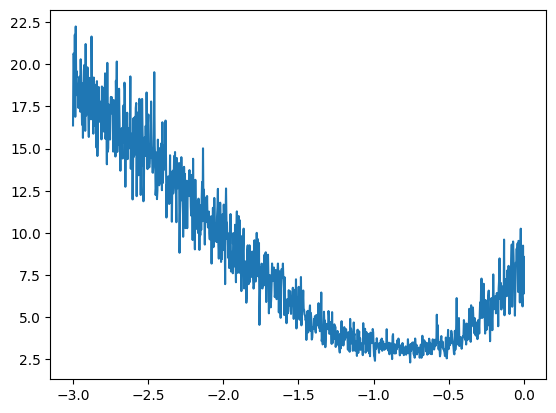

In [134]:
plt.plot(lri, lossi)

In [135]:
len(words)

32033

In [149]:
def build_dataset(words):
  block_size = 3  # context length: how many chars do we take to predict the next one
  X, Y = [], []

  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]  # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[:n2])
Xte, Yte = build_dataset(words[n2:])

In [150]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [151]:
for p in parameters:
  p.requires_grad = True

In [152]:
lri = []
lossi = []
stepi = []

In [153]:
for i in range(200000):
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # Forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward
  for p in parameters:
    p.grad = None

  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  stepi.append(i)
  lossi.append(loss.log10().item())


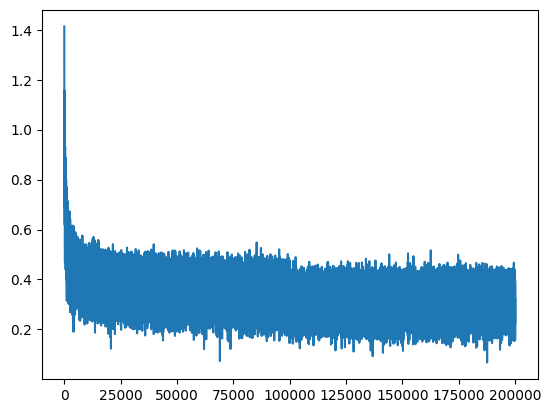

In [154]:
plt.plot(stepi, lossi)

In [155]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0669, grad_fn=<NllLossBackward0>)

In [156]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1015, grad_fn=<NllLossBackward0>)

In [157]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.4122, grad_fn=<NllLossBackward0>)

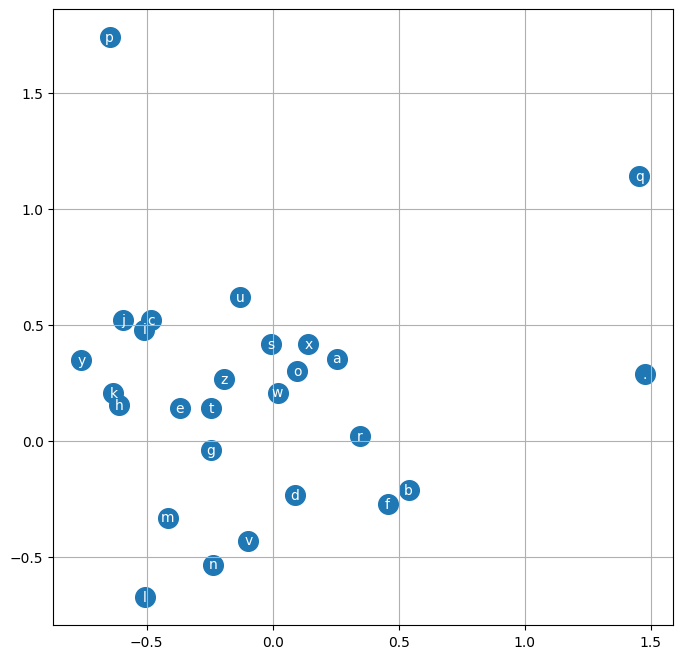

In [158]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [160]:
# sample from the mdoel

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    probs = torch.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

carmah.
amelle.
khi.
mili.
thilahnanden.
jazhith.
deliah.
jareen.
nellara.
chaiiv.
kaleigh.
ham.
evin.
quinn.
shoise.
livabi.
waxtlyn.
jarynn.
fine.
pippatley.
